## <span style="color:black"> For loading MoE models and deal with them </span>


In [1]:
import sys
sys.path.insert(1, '/home/stefano/Desktop/Stefano/scuola/uni/tesi_magistrale/code/routines')
from GW_helper import *
import matplotlib.pyplot as plt
from ML_routines import *
from EM_MoE import *
import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


Some lines to load datasets

In [2]:
theta_vector, amp_dataset, ph_dataset, frequencies = load_dataset("../datasets/GW_std_dataset_q0.dat", shuffle = False) #loading dataset
PCA_train_ph = np.loadtxt("../datasets/PCA_train_q0.dat")
PCA_test_ph = np.loadtxt("../datasets/PCA_test_q0.dat")

	#adding extra features for non linear regression
if np.all(theta_vector[:,1] == 0):
    theta_vector = np.reshape(theta_vector[:,0], (theta_vector.shape[0],1))
extra_features = np.reshape(np.power(theta_vector[:,0], -1), (theta_vector.shape[0],1))
theta_vector = np.concatenate((theta_vector, extra_features), axis = 1)

train_frac = .8

train_theta, test_theta, train_amp, test_amp = make_set_split(theta_vector, amp_dataset, train_frac, 1e-21)
train_theta, test_theta, train_ph, test_ph   = make_set_split(theta_vector, ph_dataset, train_frac, 1.)

del amp_dataset, ph_dataset, theta_vector

print("Loaded "+ str(train_theta.shape[0]+test_theta.shape[0])+" data with ",PCA_test_ph.shape[1]," features")


Loaded 5000 data with  10  features


Creating PCA model and preprocessing data

In [3]:
        #DOING PCA
print("#####PCA#####")
K_ph = PCA_train_ph.shape[1]
ph_PCA = PCA_model()
ph_PCA.load_model("../datasets/PCA_std_model_q0.dat")

rec_PCA_test_ph = ph_PCA.reconstruct_data(PCA_test_ph) #reconstructed data for phase
error_ph = np.linalg.norm(test_ph - rec_PCA_test_ph, ord= 'fro')/(test_ph.shape[0])#*np.std(test_ph))
print("Reconstruction error for phase with PCA: ",error_ph)

F_PCA = compute_mismatch(test_amp, test_ph, test_amp, rec_PCA_test_ph)
print("Mismatch PCA avg: ",np.mean(F_PCA))

	#preprocessing data
max_ph = np.max(np.abs(PCA_train_ph), axis = 0)
max_ph[np.where(max_ph > 100)] /= 10.
PCA_train_ph = np.divide(PCA_train_ph,max_ph)
PCA_test_ph = np.divide(PCA_test_ph,max_ph)


#####PCA#####
Reconstruction error for phase with PCA:  0.015772883001707965
Mismatch PCA avg:  5.55093214726049e-05


Loading models for MoE

In [4]:
MoE_models = []
gat_models = []
print("Doing MoE model for each component")
for k in range(10):
    MoE_models.append(MoE_model(1, 1))
    gat_file = "./saved_model/"+str(k)+"_gat.h5"
    exp_file = "./saved_model/"+str(k)+"_MoE.dat"
    MoE_models[k].load(exp_file,gat_file, keras.models.load_model)

Doing MoE model for each component






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Now it's time to play and make predictions properly!!!

In [5]:
PCA_fit_ph = np.zeros(PCA_test_ph.shape)
PCA_train_rec_fit =  np.zeros(PCA_train_ph.shape)
for k in range(10):
    print("Component: # ", k)
    PCA_fit_ph[:,k] = MoE_models[k].predict(test_theta)
    PCA_train_rec_fit[:,k] = MoE_models[k].predict(train_theta)
    noise_est_train = np.divide(PCA_train_ph[:,k] - PCA_train_rec_fit[:,k], PCA_train_ph[:,k])
    noise_est_test = np.divide(PCA_test_ph[:,k] - PCA_fit_ph[:,k], PCA_test_ph[:,k])
    print("\tMin/max value / scale: ", np.min(PCA_train_ph[:,k]), np.max(PCA_train_ph[:,k]), max_ph[k])
    print("\tTrain reconstruction error for comp #"+str(k)+": ", np.mean(noise_est_train), np.std(noise_est_train))
    print("\tTest reconstruction error for comp #"+str(k)+": ", np.mean(noise_est_test), np.std(noise_est_test))
    mse_train = np.sqrt(np.mean(np.square(PCA_train_rec_fit[:,k]-PCA_train_ph[:,k])))#/train_theta.shape[0]
    mse_test = np.sqrt(np.mean(np.square(PCA_test_ph[:,k]-PCA_fit_ph[:,k])))#/test_theta.shape[0]
    print("\ttrain square loss: ",mse_train)
    print("\ttest square loss: ",mse_test)
    print("\ttest loss on phase scale: ", mse_test*max_ph[k]*np.max(np.abs(ph_PCA.get_PCA_params()[0][:,k])))

Component: #  0
	Min/max value / scale:  -10.0 3.6914839128640473 1096.0657405395993
	Train reconstruction error for comp #0:  -0.00764690044292899 0.30012678817131483
	Test reconstruction error for comp #0:  0.0034279232412960043 0.23397569078581482
	train square loss:  0.07576822963897771
	test square loss:  0.07344102618905292
	test loss on phase scale:  1.8248687141332889
Component: #  1
	Min/max value / scale:  -0.442731394008255 1.0 40.13191544453933
	Train reconstruction error for comp #1:  0.2096519213527491 3.446425361241901
	Test reconstruction error for comp #1:  0.15769731094009648 1.0325637942664172
	train square loss:  0.12712567854307766
	test square loss:  0.12165986043195337
	test loss on phase scale:  0.18924613608493077
Component: #  2
	Min/max value / scale:  -1.0 0.9879241751198609 20.683020397575728
	Train reconstruction error for comp #2:  0.673747776440565 26.252793599055423
	Test reconstruction error for comp #2:  -45.18482424382601 1416.1600102943303
	train sq

Overall results

Train reconstruction error for reduced coefficients:  [-6.58249829e-01 -5.62661332e-02 -1.49513046e-01 -5.59738690e-02
  2.58473455e-02 -5.91656904e-02 -1.63186231e-04 -9.40841930e-03
  2.13423630e-03 -2.15929991e-06] [83.04435197  5.1014867   5.40539449  5.67288535  1.24471235  0.39574788
  1.51431825  0.67667787  0.32909414  0.46841603]
Test reconstruction error for reduced coefficients:  [-6.26425406e+00  1.23306646e-01 -4.43671486e-01 -4.46884683e-01
  5.42627250e-02 -5.69270855e-02 -2.65608195e-02  1.03546974e-02
  8.50127096e-05  1.16180173e-02] [80.25207891  4.88088592  5.32681198  5.41187024  1.20214571  0.3154174
  1.48175962  0.59424631  0.20885476  0.45155974]
Fit reconstruction error for phase:  2.562446475851233
Fit reconstruction error for phase (scaled):  0.030355105394249425
Mismatch fit avg:  0.9602068283902189


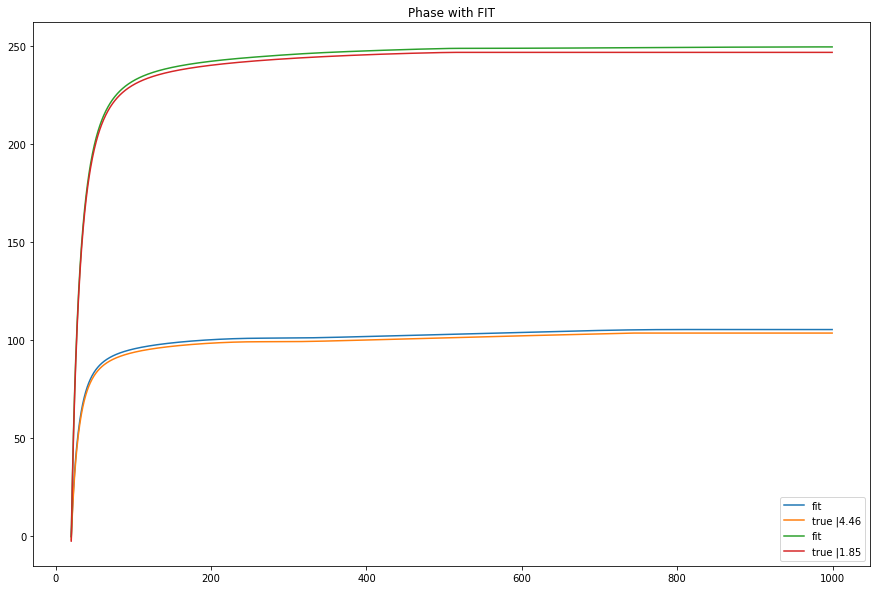

In [7]:
PCA_test_ph_full = np.multiply(PCA_test_ph, max_ph)
PCA_fit_ph_full = np.multiply(PCA_fit_ph, max_ph)
PCA_train_ph_full = np.multiply(PCA_train_ph, max_ph)
PCA_train_rec_fit_full = np.multiply(PCA_train_rec_fit, max_ph)

noise_est_train = np.divide(PCA_train_ph_full - PCA_train_rec_fit_full,1)# PCA_train_ph_full)
noise_est = np.divide(PCA_test_ph_full - PCA_fit_ph_full, 1)#PCA_test_ph_full)
print("Train reconstruction error for reduced coefficients: ", np.mean(noise_est_train, axis = 0), np.std(noise_est_train, axis =0))
print("Test reconstruction error for reduced coefficients: ", np.mean(noise_est, axis = 0), np.std(noise_est, axis = 0))

rec_fit_ph = ph_PCA.reconstruct_data(PCA_fit_ph_full)
rec_train_ph = ph_PCA.reconstruct_data(PCA_train_rec_fit_full)

error_ph = np.linalg.norm(test_ph - rec_fit_ph, ord= 'fro')/(test_ph.shape[0])
print("Fit reconstruction error for phase: ", error_ph)
print("Fit reconstruction error for phase (scaled): ", error_ph/np.std(test_ph))

plt.figure(2, figsize=(15,10))
plt.title("Phase with FIT")
for i in range(2):
    #plt.plot(frequencies, test_ph[i,:], label = 'true |' + str(np.round(test_theta[i,0],2))+","+ str(np.round(test_theta[i,1],2))+","+ str(np.round(test_theta[i,2],2)))
    plt.plot(frequencies, rec_fit_ph[i,:], label = 'fit')
    plt.plot(frequencies, test_ph[i,:], label = 'true |' + str(np.round(test_theta[i,0],2)))
plt.legend()

F = compute_mismatch(test_amp, test_ph, test_amp, rec_fit_ph)
print("Mismatch fit avg: ",np.mean(F))

Studying differences between true and fitted

0.13913772162274377


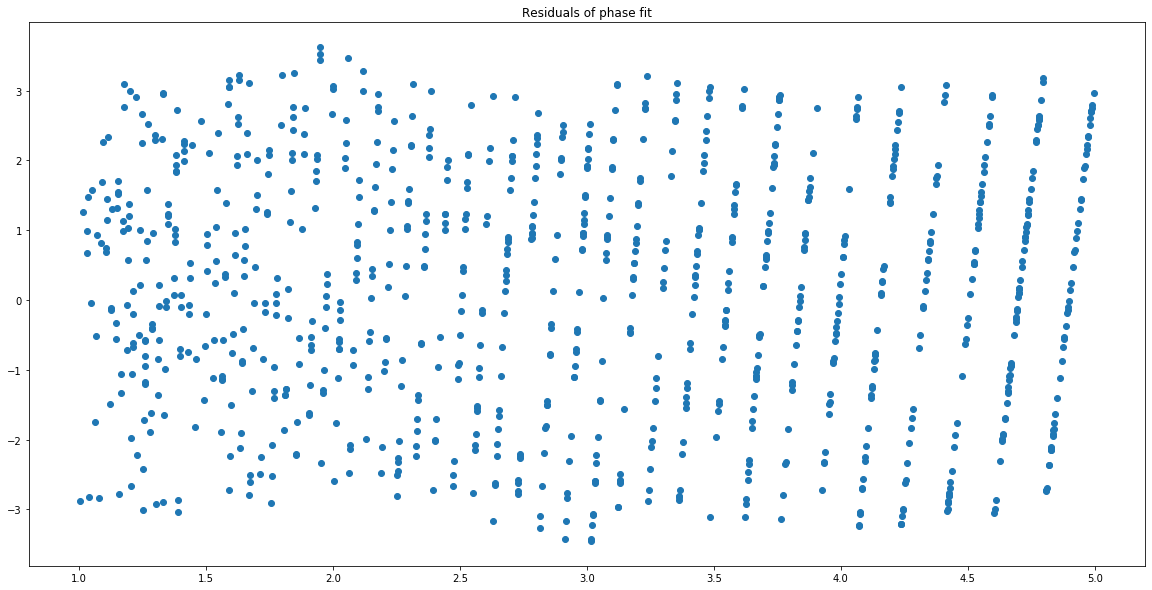

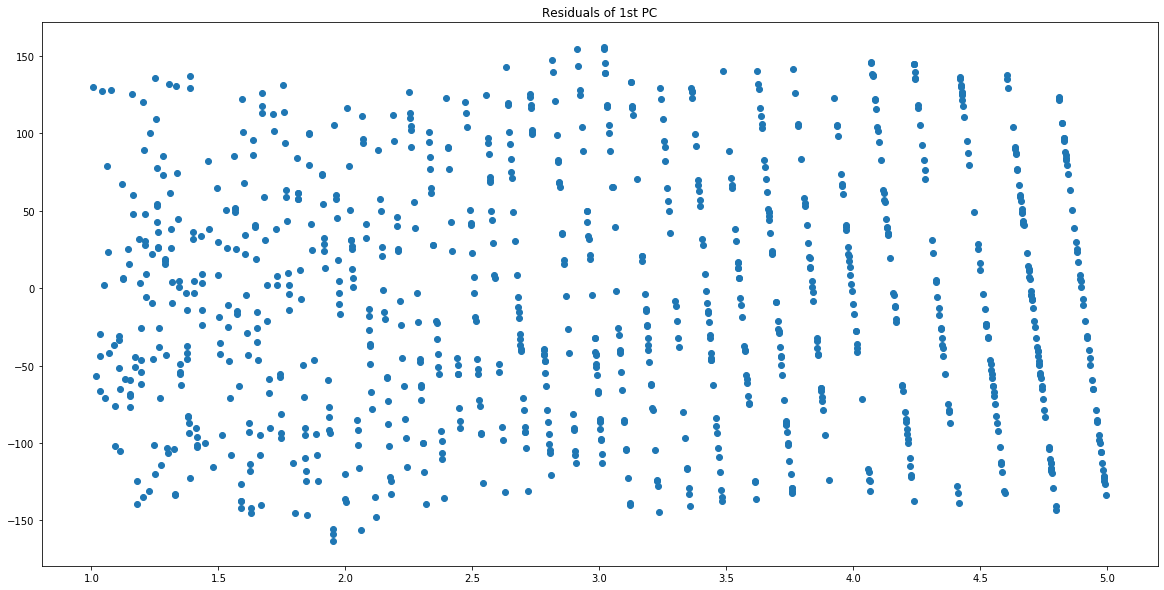

In [8]:
plt.figure(figsize=(20,10))
plt.title("Residuals of phase fit")
diff = np.mean(test_ph - rec_fit_ph, axis = 1)
plt.scatter(test_theta[:,0], diff)

plt.figure(figsize=(20,10))
plt.title("Residuals of 1st PC")
plt.scatter(test_theta[:,0], noise_est[:,0])
#plt.legend()
print(np.mean(diff))

Trying to fit residuals with another model

In [9]:
    #trying to fit residuals with NN
train_diff = np.mean(train_ph - rec_train_ph, axis = 1)
test_diff = np.mean(test_ph - rec_fit_ph, axis = 1)

diff_model = keras.Sequential()
diff_model.add(keras.layers.Dense(15, input_dim=train_theta.shape[1], activation='sigmoid'))
diff_model.add(keras.layers.Dense(5, activation='sigmoid'))
diff_model.add(keras.layers.Dense(1, activation='linear'))
diff_model.compile(loss='mse', optimizer='sgd', metrics=['mse'])
diff_model.fit(train_theta, train_diff, epochs = 10, verbose = 2)

print(diff_model.evaluate(test_theta, test_diff, verbose =0)[0])


Epoch 1/10
 - 1s - loss: 3.4628 - mean_squared_error: 3.4628
Epoch 2/10
 - 0s - loss: 3.3990 - mean_squared_error: 3.3990
Epoch 3/10
 - 0s - loss: 3.4001 - mean_squared_error: 3.4001
Epoch 4/10
 - 0s - loss: 3.3984 - mean_squared_error: 3.3984
Epoch 5/10
 - 0s - loss: 3.3958 - mean_squared_error: 3.3958
Epoch 6/10
 - 0s - loss: 3.3980 - mean_squared_error: 3.3980
Epoch 7/10
 - 0s - loss: 3.3980 - mean_squared_error: 3.3980
Epoch 8/10
 - 0s - loss: 3.3982 - mean_squared_error: 3.3982
Epoch 9/10
 - 0s - loss: 3.4006 - mean_squared_error: 3.4006
Epoch 10/10
 - 0s - loss: 3.3971 - mean_squared_error: 3.3971
3.201236125946045


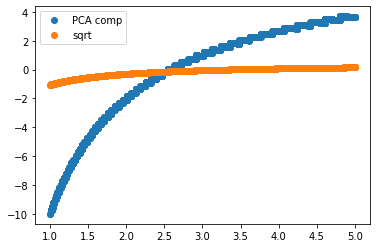

In [10]:
    #this might be a good preprocessing for dealing with fit
comp = 0
theta_val = 0
plt.plot(train_theta[:,theta_val], PCA_train_ph[:,comp], 'o', label = 'PCA comp')
plt.plot(train_theta[:,theta_val], (-np.power(train_theta[:,comp], -1))*1.5 +.45 + .00000015,'o', label = 'sqrt')
plt.legend()
plt.show()

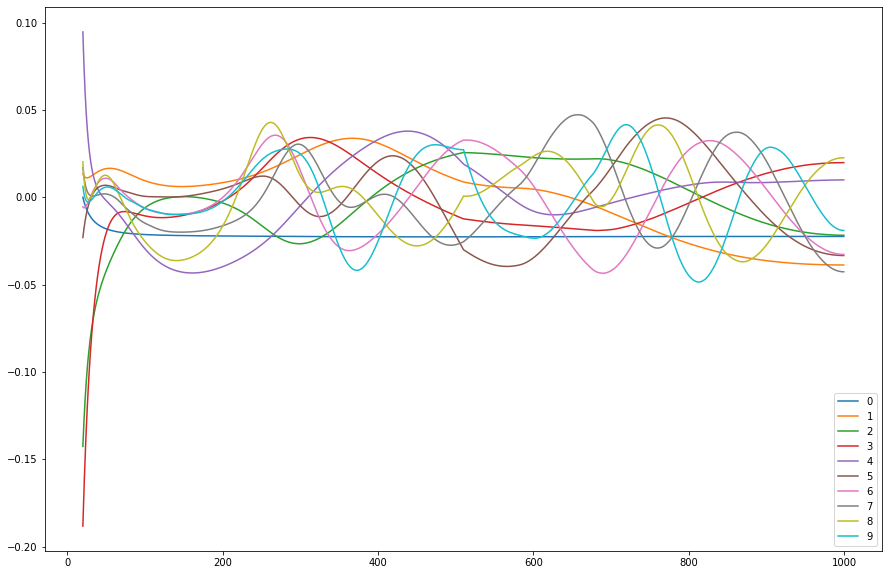

In [11]:
#plotting principal components
plt.figure(figsize=(15,10))
for k in range(10):
    plt.plot(frequencies, ph_PCA.get_PCA_params()[0][:,k], label = str(k))
    plt.legend()
plt.show()

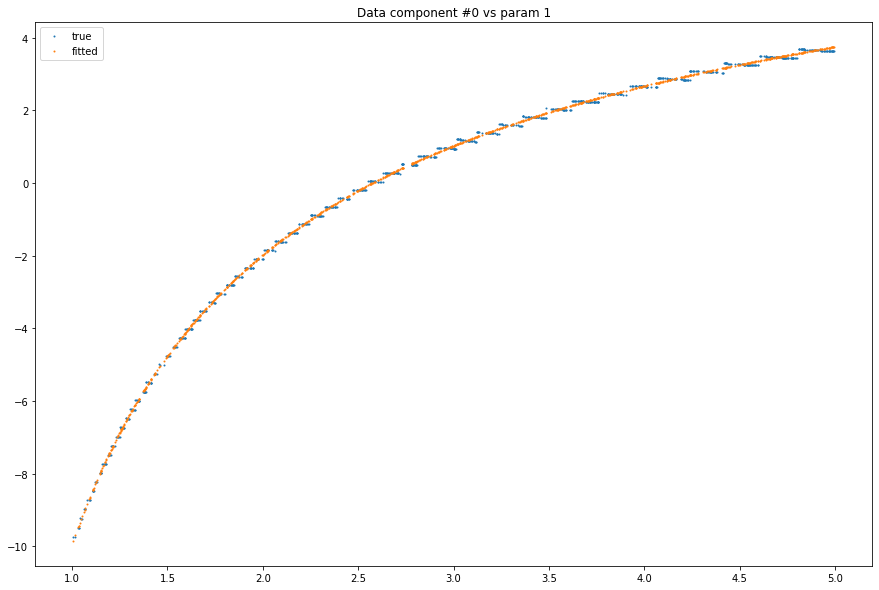

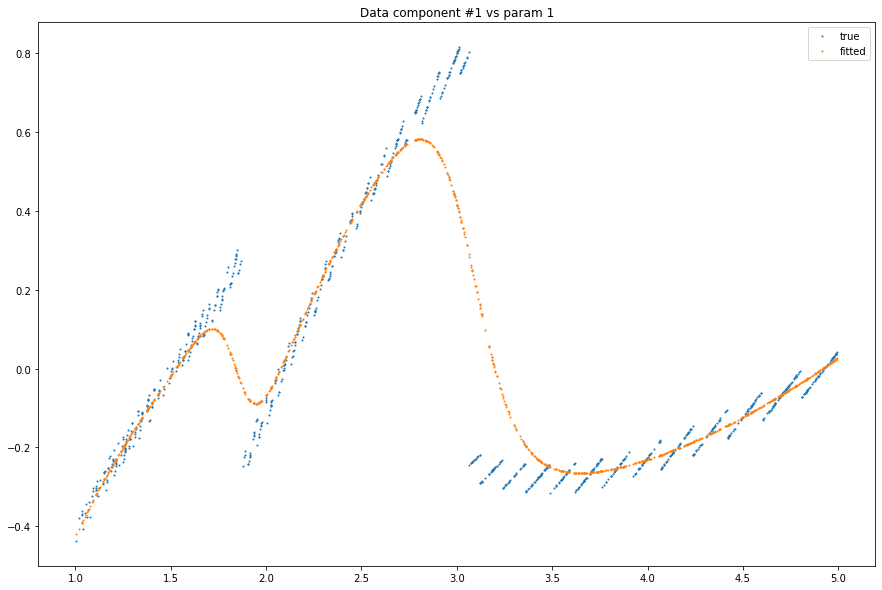

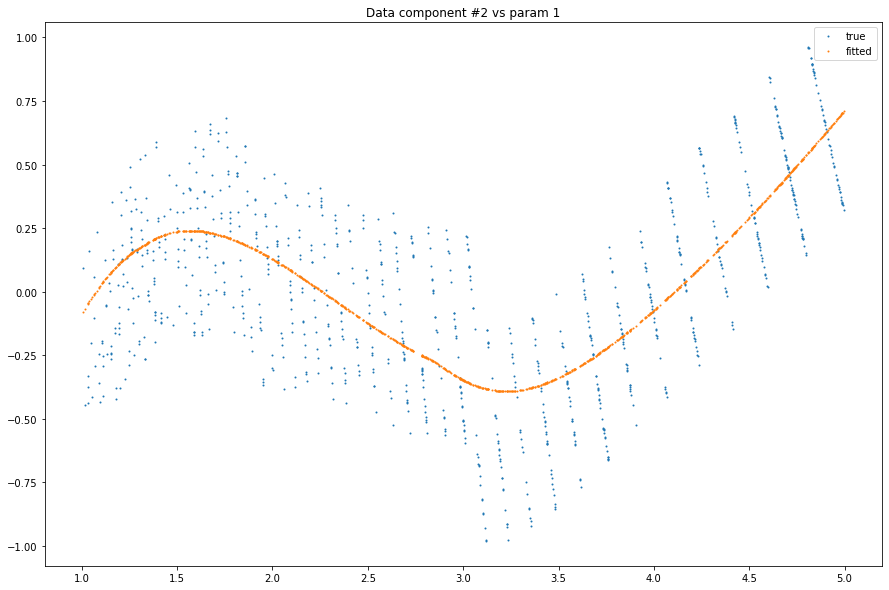

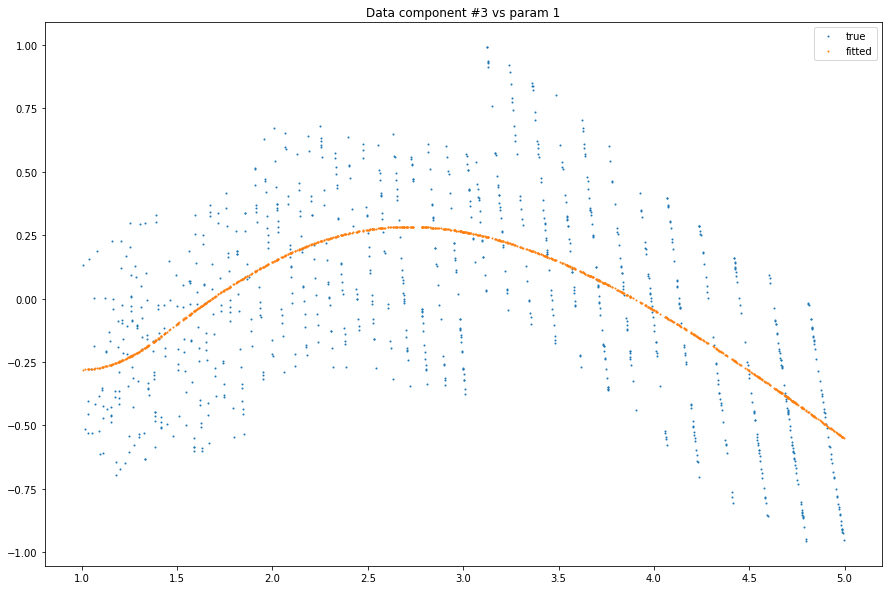

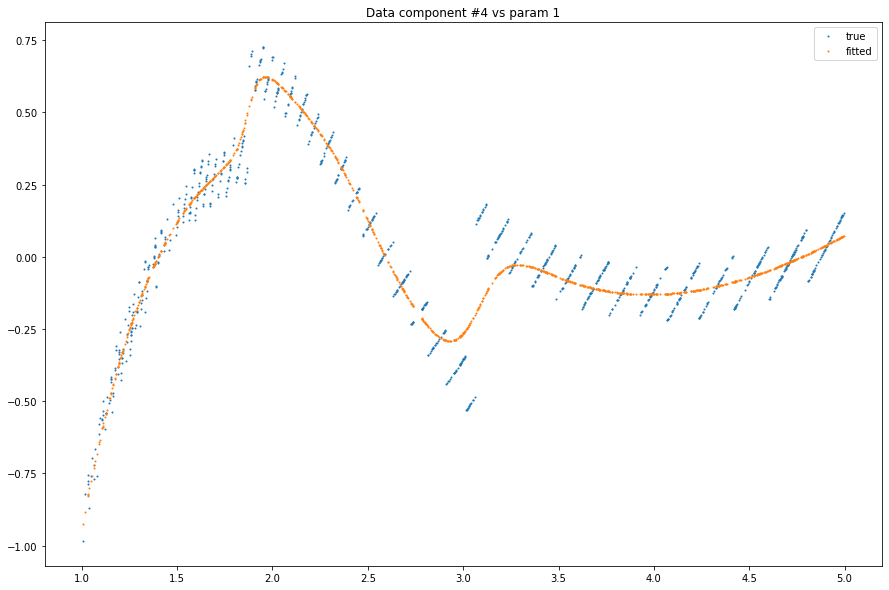

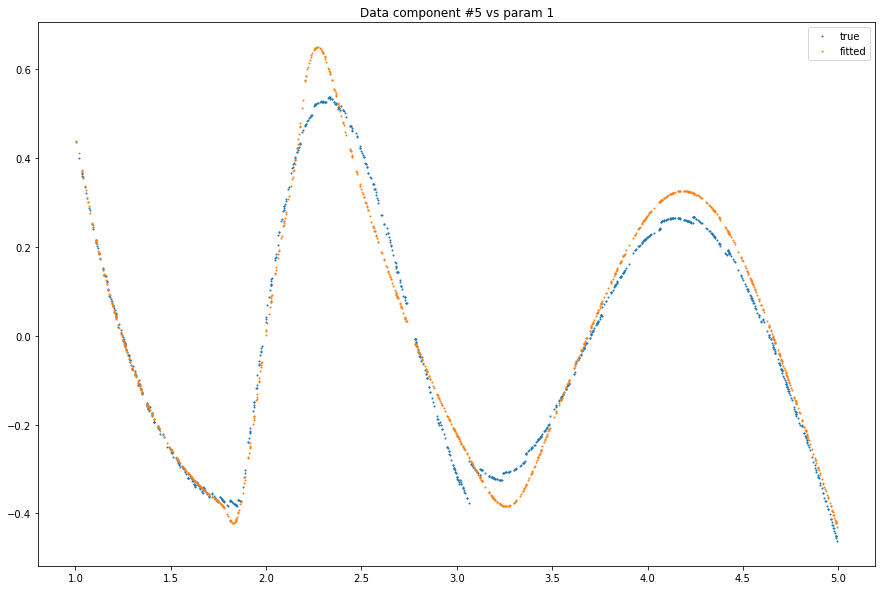

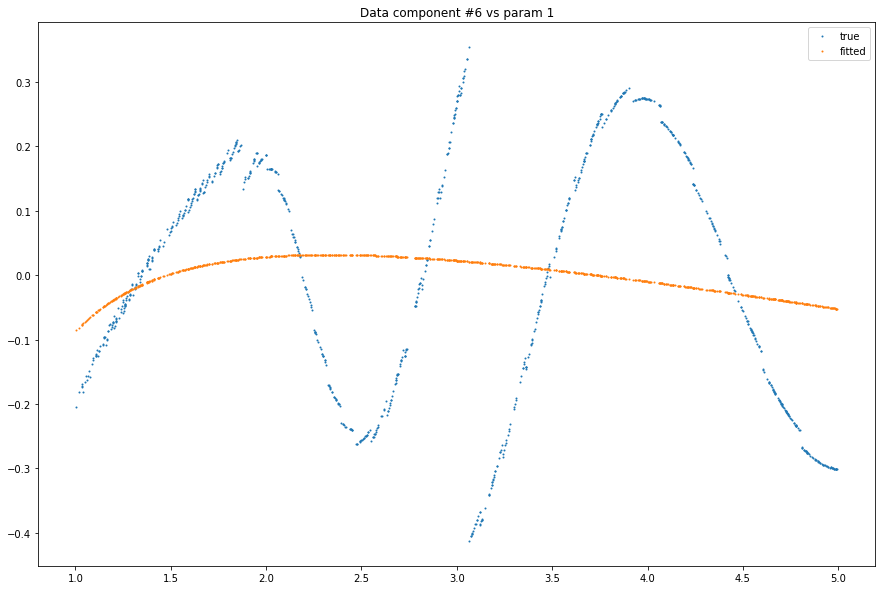

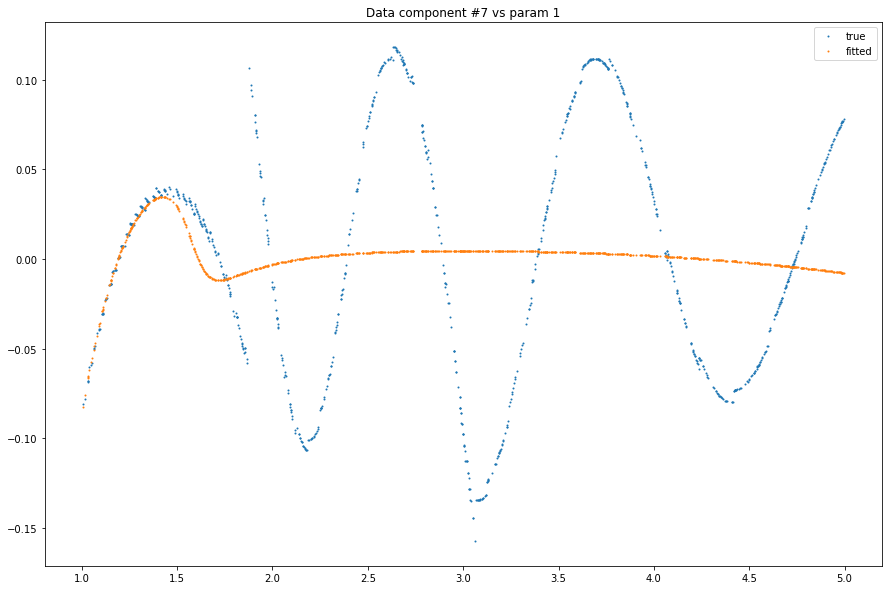

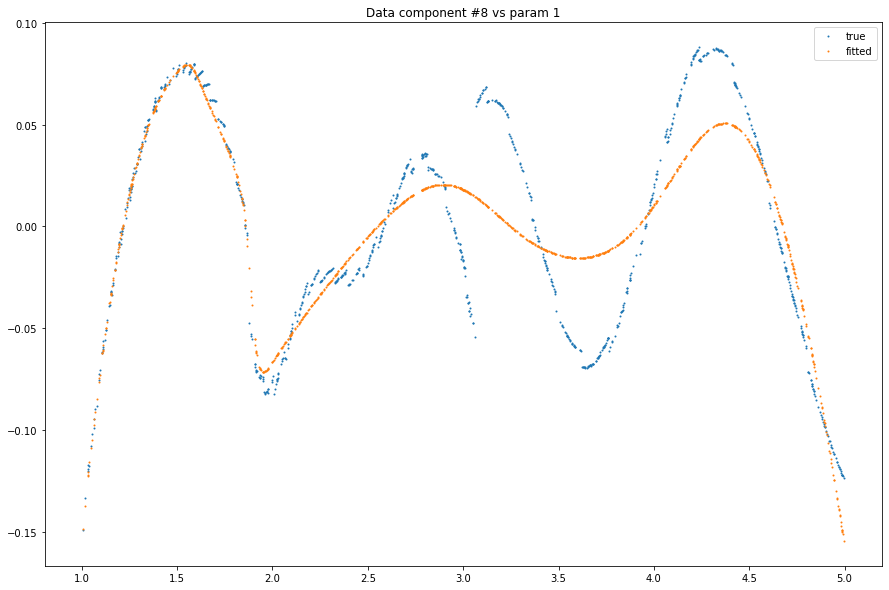

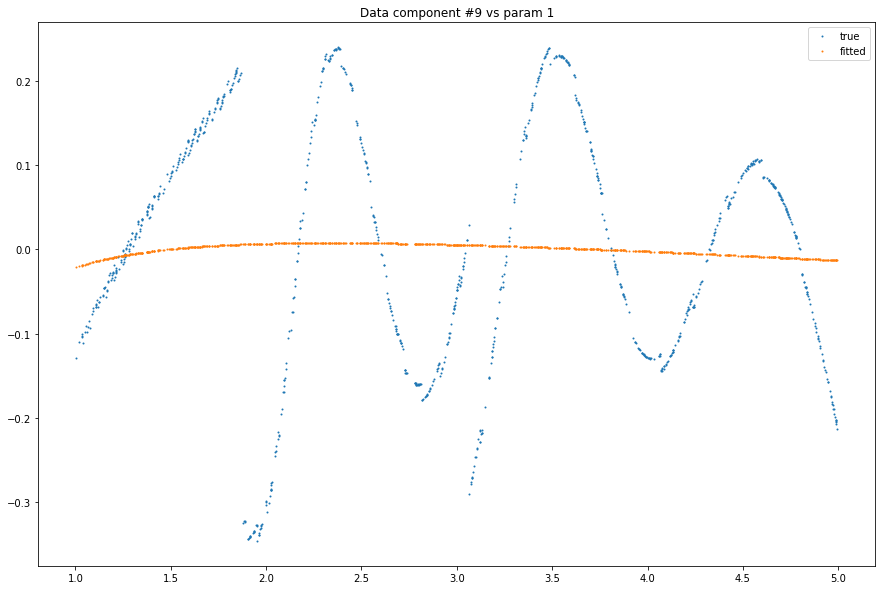

In [23]:
#plotting results of the fit
for comp in range(10):
    plt.figure(comp,figsize = (15,10))
    plt.title("Data component #"+str(comp)+" vs param "+str(i))
    plt.plot(test_theta[:,0], PCA_test_ph[:,comp], 'o',label = 'true', ms = 1)
    plt.plot(test_theta[:,0], PCA_fit_ph[:,comp], 'o',label = 'fitted', ms = 1)
    plt.legend()